In [1]:
!pip install --upgrade scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 78.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spaghetti 1.7.6 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.1 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


# import lib

In [2]:
import os 
import cv2
import sys
import math
import copy
import timm
import torch
import random
import requests
import numpy as np
import torchvision
import pandas as pd
import torch.nn as nn
from PIL import Image
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.models as models
from torchvision.transforms import v2
import torchvision.datasets as datasets
from torch.distributions.beta import Beta
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder

# preprocess multilabel

In [3]:
# def process_label_kl(label_unprocess):
#     if label_unprocess == 2:
#         label_unprocess = 1
#     if label_unprocess == 3 or label_unprocess == 4:
#         label_unprocess = 2
#     return label_unprocess

In [4]:
df = pd.read_csv("/kaggle/input/oai-clinical/oai-clinical/multilabel_missing-filled.csv")
df.head(5)

,id,side,subset,filename,kl_grade,osteophytes,jsn,osfl,scfl,cyfl,...,cytm,attm,osfm,scfm,cyfm,ostl,sctl,cytl,attl,actual_path
0,9000099,L,train,9000099L.png,3,def,severe,2.0,2.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,/kaggle/input/knee-osteoarthritis-dataset-with...
1,9000099,R,train,9000099R.png,2,def,mild/mod,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,/kaggle/input/knee-osteoarthritis-dataset-with...
2,9000296,L,train,9000296L.png,3,poss,def,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/kaggle/input/knee-osteoarthritis-dataset-with...
3,9000296,R,train,9000296R.png,2,def,none,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/kaggle/input/knee-osteoarthritis-dataset-with...
4,9000622,L,train,9000622L.png,1,none,none,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/kaggle/input/knee-osteoarthritis-dataset-with...


In [5]:
# df["kl_grade"] = df["kl_grade"].map(process_label_kl)

In [6]:
df.head(5)

,id,side,subset,filename,kl_grade,osteophytes,jsn,osfl,scfl,cyfl,...,cytm,attm,osfm,scfm,cyfm,ostl,sctl,cytl,attl,actual_path
0,9000099,L,train,9000099L.png,3,def,severe,2.0,2.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,/kaggle/input/knee-osteoarthritis-dataset-with...
1,9000099,R,train,9000099R.png,2,def,mild/mod,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,/kaggle/input/knee-osteoarthritis-dataset-with...
2,9000296,L,train,9000296L.png,3,poss,def,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/kaggle/input/knee-osteoarthritis-dataset-with...
3,9000296,R,train,9000296R.png,2,def,none,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/kaggle/input/knee-osteoarthritis-dataset-with...
4,9000622,L,train,9000622L.png,1,none,none,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/kaggle/input/knee-osteoarthritis-dataset-with...


In [7]:
TARGET_COLS = df.columns[4:-1].tolist()
TARGET_COLS = [c for c in TARGET_COLS if not (c.startswith("cy") or c.startswith("at"))]
# TARGET_COLS = ['kl_grade', 'osteophytes', 'jsn']
# part = 'sctm'
# TARGET_COLS = [part]
target_values = {c:np.sort(df[c].dropna().unique()).tolist() for c in TARGET_COLS}
target_values

{'kl_grade': [0, 1, 2, 3, 4],
 'osteophytes': ['def', 'none', 'poss'],
 'jsn': ['def', 'mild/mod', 'none', 'severe'],
 'osfl': [0.0, 1.0, 2.0, 3.0],
 'scfl': [0.0, 1.0, 2.0, 3.0],
 'ostm': [0.0, 1.0, 2.0, 3.0],
 'sctm': [0.0, 1.0, 2.0, 3.0],
 'osfm': [0.0, 1.0, 2.0, 3.0],
 'scfm': [0.0, 1.0, 2.0, 3.0],
 'ostl': [0.0, 1.0, 2.0, 3.0],
 'sctl': [0.0, 1.0, 2.0, 3.0]}

In [8]:
onehot = OneHotEncoder(categories=list(target_values.values()))
onehot.fit(df[TARGET_COLS].dropna())

OneHotEncoder(categories=[[0, 1, 2, 3, 4], ['def', 'none', 'poss'],
                          ['def', 'mild/mod', 'none', 'severe'],
                          [0.0, 1.0, 2.0, 3.0], [0.0, 1.0, 2.0, 3.0],
                          [0.0, 1.0, 2.0, 3.0], [0.0, 1.0, 2.0, 3.0],
                          [0.0, 1.0, 2.0, 3.0], [0.0, 1.0, 2.0, 3.0],
                          [0.0, 1.0, 2.0, 3.0], [0.0, 1.0, 2.0, 3.0]])

In [9]:
test_nan_df = ~df.loc[df['subset'] == 'test', TARGET_COLS].isna()
test_nan_df

,kl_grade,osteophytes,jsn,osfl,scfl,ostm,sctm,osfm,scfm,ostl,sctl
8,True,True,True,False,False,False,False,False,False,False,False
9,True,True,True,False,False,False,False,False,False,False,False
26,True,True,True,False,False,False,False,False,False,False,False
27,True,True,True,False,False,False,False,False,False,False,False
28,True,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...
8245,True,True,True,True,True,True,True,True,True,True,True
8246,True,True,True,True,True,True,True,True,True,True,True
8247,True,True,True,True,True,True,True,True,True,True,True
8254,True,True,True,True,True,True,True,True,True,True,True


In [10]:
X_train = df[df['subset'] == 'train']['actual_path'].tolist()
y_train = onehot.transform(df.loc[df['subset'] == 'train', TARGET_COLS]).toarray().astype('uint8')

X_val = df[df['subset'] == 'val'].dropna()['actual_path'].tolist()
y_val = onehot.transform(df.loc[df['subset'] == 'val', TARGET_COLS].dropna()).toarray().astype('uint8')

X_test = df[df['subset'] == 'test']['actual_path'].tolist()
y_test = onehot.transform(df.loc[df['subset'] == 'test', TARGET_COLS].fillna(0)).toarray().astype('uint8')

In [11]:
len(X_val)

500

In [12]:
len(y_val)

500

# create dataset


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
HEIGHT = 224
WEIGHT = 224
BATCH_SIZE = 32

NUM_CLASSES = y_train.shape[1]
NUM_CLASSES 

44

In [15]:
class Custom_DataSet(Dataset):
    def __init__(self, X, y, transform=None):   
        self.X = X
        self.y = y
        self.transform = transform
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        # Read image
        image = cv2.imread(self.X[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # Get label
        label = self.y[index]
        
        if self.transform:
            image = self.transform(image)

        return image, label

In [16]:
class RandomCutout(torch.nn.Module):
    def __init__(self, height_factor, width_factor):
        super().__init__()
        self.height_factor = height_factor
        self.width_factor = width_factor

    def forward(self, img):
        h, w = img.size(1), img.size(2)
        cutout_height = int(random.uniform(*self.height_factor) * h)
        cutout_width = int(random.uniform(*self.width_factor) * w)
        x = random.randint(0, w - cutout_width)
        y = random.randint(0, h - cutout_height)
        img[:, y:y+cutout_height, x:x+cutout_width] = 0
        return img

class RandomSharpness(torch.nn.Module):
    def __init__(self, factor):
        super().__init__()
        self.factor = factor

    def forward(self, img):
        factor = random.uniform(*self.factor)
        return transforms.functional.adjust_sharpness(img, factor)

class RandomShear(torch.nn.Module):
    def __init__(self, x_factor, y_factor):
        super().__init__()
        self.x_factor = x_factor
        self.y_factor = y_factor

    def forward(self, img):
        x_shear = random.uniform(-self.x_factor, self.x_factor)
        y_shear = random.uniform(-self.y_factor, self.y_factor)
        return transforms.functional.affine(img, angle=0, translate=(0, 0), scale=1, shear=(x_shear, y_shear))

    

class Grid(object):
    def __init__(self, d1, d2, rotate = 1, ratio = 0.5, mode=0, prob=1.):
        self.d1 = d1
        self.d2 = d2
        self.rotate = rotate
        self.ratio = ratio
        self.mode=mode
        self.st_prob = self.prob = prob

    def set_prob(self, epoch, max_epoch):
        self.prob = self.st_prob * min(1, epoch / max_epoch)

    def __call__(self, img):
        if np.random.rand() > self.prob:
            return img
        h = img.size(1)
        w = img.size(2)
        
        # 1.5 * h, 1.5 * w works fine with the squared images
        # But with rectangular input, the mask might not be able to recover back to the input image shape
        # A square mask with edge length equal to the diagnoal of the input image 
        # will be able to cover all the image spot after the rotation. This is also the minimum square.
        hh = math.ceil((math.sqrt(h*h + w*w)))
        
        d = np.random.randint(self.d1, self.d2)
        #d = self.d
        
        # maybe use ceil? but i guess no big difference
        self.l = math.ceil(d*self.ratio)
        
        mask = np.ones((hh, hh), np.float32)
        st_h = np.random.randint(d)
        st_w = np.random.randint(d)
        for i in range(-1, hh//d+1):
                s = d*i + st_h
                t = s+self.l
                s = max(min(s, hh), 0)
                t = max(min(t, hh), 0)
                mask[s:t,:] *= 0
        for i in range(-1, hh//d+1):
                s = d*i + st_w
                t = s+self.l
                s = max(min(s, hh), 0)
                t = max(min(t, hh), 0)
                mask[:,s:t] *= 0
        r = np.random.randint(self.rotate)
        mask = Image.fromarray(np.uint8(mask))
        mask = mask.rotate(r)
        mask = np.asarray(mask)
        mask = mask[(hh-h)//2:(hh-h)//2+h, (hh-w)//2:(hh-w)//2+w]

        mask = torch.from_numpy(mask).float()
        if self.mode == 1:
            mask = 1-mask

        mask = mask.expand_as(img)
        img = img * mask 

        return img

class GridMask(nn.Module):
    def __init__(self, d1, d2, rotate = 1, ratio = 0.5, mode=0, prob=1.):
        super(GridMask, self).__init__()
        self.rotate = rotate
        self.ratio = ratio
        self.mode = mode
        self.st_prob = prob
        self.grid = Grid(d1, d2, rotate, ratio, mode, prob)

    def set_prob(self, epoch, max_epoch):
        self.grid.set_prob(epoch, max_epoch)

    def forward(self, x):
        if not self.training:
            return x
        c,h,w = x.size()
        y = self.grid(x)
        return y

In [17]:
  
class RandomAugmentationPipeline:
    def __init__(self, augmentations, min_aug=1, max_aug=3):
        self.augmentations = augmentations
        self.min_aug = min_aug
        self.max_aug = max_aug

    def __call__(self, img):
        num_aug = random.randint(self.min_aug, self.max_aug)
        augmentations = random.sample(self.augmentations, num_aug)
        for aug in augmentations:
            img = aug(img)
        return img



In [18]:
augmentations = [
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(22.5),
            RandomCutout(height_factor=(0.2, 0.4), width_factor=(0.1, 0.3)),
            transforms.RandomAffine(degrees=0, translate=(0.15, 0.25), fill=0),
            RandomSharpness(factor=(0.2, 0.6)),
            RandomShear(x_factor=0.2, y_factor=0.2),
            transforms.ColorJitter(brightness=(0.7, 1.0)),
            v2.RandomPerspective(),
]

d1 = 50  
d2 = 100  
ratio = 0.75  
rotate = 360  
mode = 1  
prob = 0.8  

grid_mask = GridMask(d1, d2, rotate, ratio, mode, prob)


random_aug_pipeline = RandomAugmentationPipeline(augmentations, min_aug=1, max_aug=3)

train_transforms = transforms.Compose([
    transforms.Resize((HEIGHT, WEIGHT)),
    transforms.ToTensor(),
    random_aug_pipeline,
    grid_mask,
    transforms.Normalize((0.6078, 0.6078, 0.6078), (0.1932, 0.1932, 0.1932))
])


val_transforms = transforms.Compose([
    transforms.Resize((HEIGHT, WEIGHT)),
    transforms.ToTensor(),
    transforms.Normalize((0.6078, 0.6078, 0.6078), (0.1932, 0.1932, 0.1932)),
])

test_transforms = transforms.Compose([
    transforms.Resize((HEIGHT, WEIGHT)),
    transforms.ToTensor(),
    transforms.Normalize((0.6078, 0.6078, 0.6078), (0.1932, 0.1932, 0.1932)),
])

train_dataset = Custom_DataSet(X=X_train, y=y_train, transform=train_transforms)
val_dataset   = Custom_DataSet(X=X_val, y=y_val, transform=val_transforms)
test_dataset  = Custom_DataSet(X=X_test, y=y_test, transform=test_transforms)

train_loader  = torch.utils.data.DataLoader(train_dataset ,shuffle=True, batch_size = 32)
val_loader    = torch.utils.data.DataLoader(val_dataset ,shuffle=False, batch_size = 32)
test_loader   = torch.utils.data.DataLoader(test_dataset ,shuffle=False, batch_size =1)

In [19]:
for sample, label in train_loader:
    print(sample.shape)
    print(label.shape)
    break

/tmp/ipykernel_23/1312260044.py:89: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  mask = torch.from_numpy(mask).float()


torch.Size([32, 3, 224, 224])
torch.Size([32, 44])


In [20]:
def show_images(images, labels):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))
        plt.title(np.argmax(labels[i][0:5]).item())
        plt.axis('off')
    plt.show()

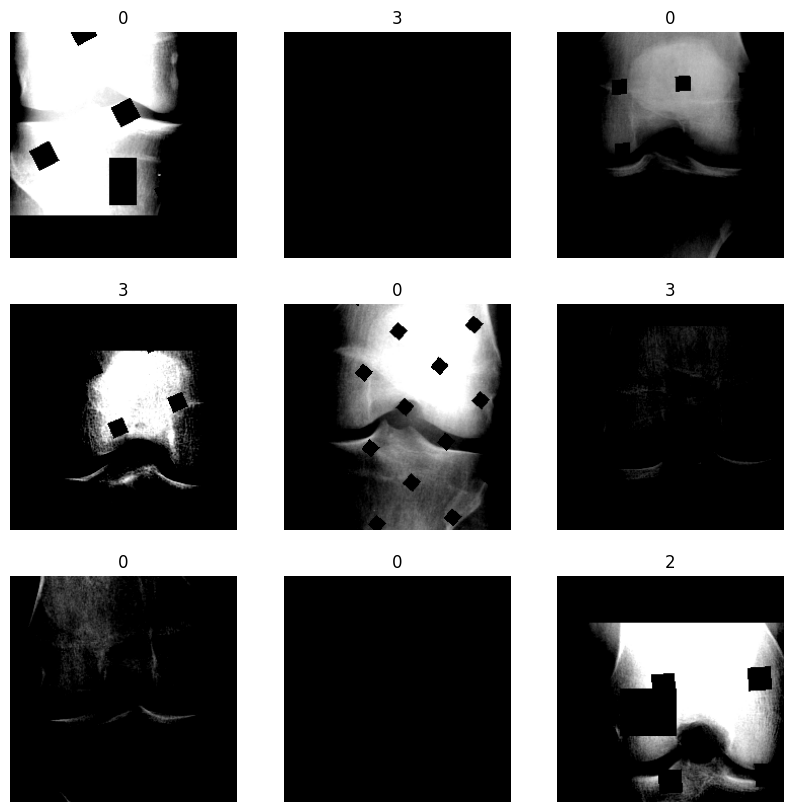

In [21]:
# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
show_images(images, labels)

# Create Model 

In [22]:
model = models.convnext_base(weights='IMAGENET1K_V1')
num_features = model.classifier[2].in_features
model.classifier[2] = nn.Sequential(
            nn.Linear(num_features, NUM_CLASSES),
            nn.Sigmoid()
        )
model.to(device)

Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth
100%|██████████| 338M/338M [00:04<00:00, 79.6MB/s]


ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

In [23]:
criterion = nn.BCELoss()  # Sử dụng BCELoss
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       mode='max',
                                                       factor=0.5,
                                                       patience=5,
                                                       threshold=1e-3,
                                                       threshold_mode='abs',
                                                       verbose=True
                                                       )
val_acc_max = 0.0

In [24]:
num_epochs = 30

loss_epochs = []
loss_val_epochs = []
acc_epochs = []
acc_eval_epochs = []

for epoch in range(num_epochs):
    # Training model 
    num_acc = 0.0
    running_loss = 0.0
    model.train()
    for inputs, labels in tqdm(train_loader):
        optimizer.zero_grad()
        
        inputs  = inputs.to(device)
        labels  = labels.to(device)
        labels = labels.float()
        
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        
        # Tính toán binary accuracy
        predictions = outputs >= 0.5
        num_acc += (predictions == labels).float().sum().item() / labels.size(1)
        
    epoch_loss = running_loss / len(train_loader.dataset)
    acc = num_acc / len(train_loader.dataset)

    loss_epochs.append(epoch_loss)
    acc_epochs.append(acc)
    
    # Evaluate model on epoch    
    num_val_acc = 0.0
    running_val_loss = 0.0
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):

            inputs  = inputs.to(device)
            labels  = labels.to(device)
            labels = labels.float()

            outputs = model(inputs)

            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * inputs.size(0)
            
            # Tính toán binary accuracy
            predictions = outputs >= 0.5
            num_val_acc += (predictions == labels).float().sum().item() / labels.size(1)
    
    val_loss = running_val_loss / len(val_loader.dataset)
    val_acc = num_val_acc / len(val_loader.dataset)    

    loss_val_epochs.append(val_loss)
    acc_eval_epochs.append(val_acc)
    
    scheduler.step(val_acc)
    
    if val_acc > val_acc_max:
        print('Validation acc increased ({:.6f} --> {:.6f}).   Saving model ...'.format(val_acc_max, val_acc))
        torch.save(model.state_dict(), '/kaggle/working/model.pt')
        val_acc_max = val_acc
        
    print("Epoch", epoch + 1)
    print(f"Loss: {epoch_loss:.4f}, Train_acc: {acc*100:.2f}")  
    print(f"Val_loss: {val_loss:.4f}, Val_acc: {val_acc*100:.2f}")

100%|██████████| 16/16 [00:06<00:00,  2.32it/s]


Validation acc increased (0.000000 --> 0.857955).   Saving model ...
Epoch 1
Loss: 0.3230, Train_acc: 86.73
Val_loss: 0.3217, Val_acc: 85.80


100%|██████████| 16/16 [00:04<00:00,  3.36it/s]


Validation acc increased (0.857955 --> 0.872136).   Saving model ...
Epoch 2
Loss: 0.2499, Train_acc: 89.26
Val_loss: 0.2940, Val_acc: 87.21


100%|██████████| 16/16 [00:04<00:00,  3.40it/s]


Validation acc increased (0.872136 --> 0.885591).   Saving model ...
Epoch 3
Loss: 0.2259, Train_acc: 90.17
Val_loss: 0.2632, Val_acc: 88.56


100%|██████████| 16/16 [00:04<00:00,  3.35it/s]


Validation acc increased (0.885591 --> 0.888545).   Saving model ...
Epoch 4
Loss: 0.2124, Train_acc: 90.69
Val_loss: 0.2540, Val_acc: 88.85


100%|██████████| 16/16 [00:04<00:00,  3.29it/s]


Validation acc increased (0.888545 --> 0.891455).   Saving model ...
Epoch 5
Loss: 0.2055, Train_acc: 91.02
Val_loss: 0.2494, Val_acc: 89.15


100%|██████████| 16/16 [00:04<00:00,  3.39it/s]


Epoch 6
Loss: 0.2000, Train_acc: 91.22
Val_loss: 0.2448, Val_acc: 88.96


100%|██████████| 16/16 [00:04<00:00,  3.30it/s]


Validation acc increased (0.891455 --> 0.893091).   Saving model ...
Epoch 7
Loss: 0.1945, Train_acc: 91.44
Val_loss: 0.2420, Val_acc: 89.31


100%|██████████| 16/16 [00:04<00:00,  3.31it/s]


Validation acc increased (0.893091 --> 0.895136).   Saving model ...
Epoch 8
Loss: 0.1908, Train_acc: 91.60
Val_loss: 0.2403, Val_acc: 89.51


100%|██████████| 16/16 [00:04<00:00,  3.26it/s]


Epoch 9
Loss: 0.1856, Train_acc: 91.90
Val_loss: 0.2426, Val_acc: 89.43


100%|██████████| 16/16 [00:04<00:00,  3.38it/s]


Epoch 10
Loss: 0.1814, Train_acc: 92.03
Val_loss: 0.2423, Val_acc: 89.48


100%|██████████| 16/16 [00:04<00:00,  3.40it/s]


Epoch 11
Loss: 0.1757, Train_acc: 92.34
Val_loss: 0.2440, Val_acc: 89.18


100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


Epoch 12
Loss: 0.1726, Train_acc: 92.55
Val_loss: 0.2452, Val_acc: 89.40


100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


Validation acc increased (0.895136 --> 0.896682).   Saving model ...
Epoch 13
Loss: 0.1706, Train_acc: 92.58
Val_loss: 0.2405, Val_acc: 89.67


100%|██████████| 16/16 [00:04<00:00,  3.41it/s]


Epoch 14
Loss: 0.1661, Train_acc: 92.85
Val_loss: 0.2446, Val_acc: 89.33


100%|██████████| 16/16 [00:04<00:00,  3.39it/s]


Epoch 15
Loss: 0.1602, Train_acc: 93.08
Val_loss: 0.2484, Val_acc: 89.22


100%|██████████| 16/16 [00:04<00:00,  3.41it/s]


Epoch 16
Loss: 0.1576, Train_acc: 93.21
Val_loss: 0.2489, Val_acc: 89.35


100%|██████████| 16/16 [00:04<00:00,  3.38it/s]


Epoch 17
Loss: 0.1516, Train_acc: 93.54
Val_loss: 0.2503, Val_acc: 89.20


100%|██████████| 16/16 [00:04<00:00,  3.37it/s]


Epoch 18
Loss: 0.1468, Train_acc: 93.75
Val_loss: 0.2535, Val_acc: 89.33


100%|██████████| 16/16 [00:04<00:00,  3.42it/s]


Epoch 00019: reducing learning rate of group 0 to 5.0000e-05.
Epoch 19
Loss: 0.1420, Train_acc: 94.03
Val_loss: 0.2556, Val_acc: 89.34


100%|██████████| 16/16 [00:04<00:00,  3.38it/s]


Epoch 20
Loss: 0.1298, Train_acc: 94.66
Val_loss: 0.2542, Val_acc: 89.43


100%|██████████| 16/16 [00:04<00:00,  3.38it/s]


Epoch 21
Loss: 0.1232, Train_acc: 95.00
Val_loss: 0.2602, Val_acc: 89.38


100%|██████████| 16/16 [00:04<00:00,  3.41it/s]


Epoch 22
Loss: 0.1195, Train_acc: 95.19
Val_loss: 0.2621, Val_acc: 89.37


100%|██████████| 16/16 [00:04<00:00,  3.36it/s]


Epoch 23
Loss: 0.1169, Train_acc: 95.26
Val_loss: 0.2655, Val_acc: 89.25


100%|██████████| 16/16 [00:04<00:00,  3.37it/s]


Epoch 24
Loss: 0.1129, Train_acc: 95.43
Val_loss: 0.2672, Val_acc: 89.30


100%|██████████| 16/16 [00:04<00:00,  3.40it/s]


Epoch 00025: reducing learning rate of group 0 to 2.5000e-05.
Epoch 25
Loss: 0.1120, Train_acc: 95.54
Val_loss: 0.2716, Val_acc: 89.31


100%|██████████| 16/16 [00:04<00:00,  3.38it/s]


Epoch 26
Loss: 0.1033, Train_acc: 95.98
Val_loss: 0.2714, Val_acc: 89.39


100%|██████████| 16/16 [00:04<00:00,  3.36it/s]


Epoch 27
Loss: 0.1009, Train_acc: 96.05
Val_loss: 0.2734, Val_acc: 89.34


100%|██████████| 16/16 [00:04<00:00,  3.41it/s]


Epoch 28
Loss: 0.0990, Train_acc: 96.16
Val_loss: 0.2787, Val_acc: 89.38


100%|██████████| 16/16 [00:04<00:00,  3.40it/s]


Epoch 29
Loss: 0.0950, Train_acc: 96.35
Val_loss: 0.2780, Val_acc: 89.19


100%|██████████| 16/16 [00:04<00:00,  3.45it/s]

Epoch 30
Loss: 0.0927, Train_acc: 96.39
Val_loss: 0.2807, Val_acc: 89.16


In [25]:
model.load_state_dict(torch.load('/kaggle/working/model.pt'))

<All keys matched successfully>

In [26]:
y_pred = []
y_true = []
test_acc = 0.0
model.eval()
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):

        inputs  = inputs.to(device)
        labels  = labels.to(device)
        y_true.append(labels.cpu())
        
        labels = labels.float()

        outputs = model(inputs)

        y_pred.append(outputs.cpu())
        
        predictions = outputs >= 0.5
        test_acc += (predictions == labels).float().sum().item() / labels.size(1)
        
test_acc = (test_acc * 100) / len(test_dataset)
test_acc

100%|██████████| 1656/1656 [00:32<00:00, 50.40it/s]


91.85331576636004

In [27]:
y_true = np.squeeze(y_true, axis=1)
y_pred = np.squeeze(y_pred, axis=1)

KL_GRADE
Accuracy: 0.7210144927536232
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.88      0.82       639
           1       0.42      0.40      0.41       296
           2       0.76      0.65      0.70       447
           3       0.83      0.81      0.82       223
           4       0.86      0.82      0.84        51

    accuracy                           0.72      1656
   macro avg       0.73      0.71      0.72      1656
weighted avg       0.72      0.72      0.72      1656



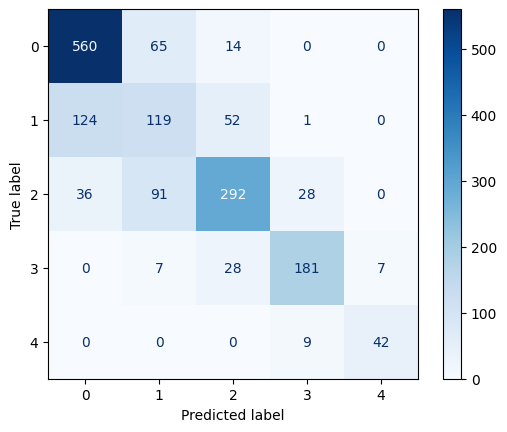

OSTEOPHYTES
Accuracy: 0.7053140096618358
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.79      0.82       746
           1       0.59      0.60      0.60       358
           2       0.61      0.66      0.63       552

    accuracy                           0.71      1656
   macro avg       0.68      0.68      0.68      1656
weighted avg       0.71      0.71      0.71      1656



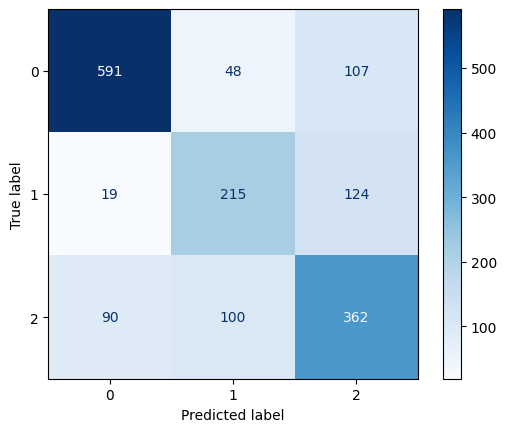

JSN
Accuracy: 0.7590579710144928
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.38      0.33      0.36       218
           1       0.69      0.67      0.68       327
           2       0.84      0.87      0.85      1015
           3       0.85      0.85      0.85        96

    accuracy                           0.76      1656
   macro avg       0.69      0.68      0.69      1656
weighted avg       0.75      0.76      0.75      1656



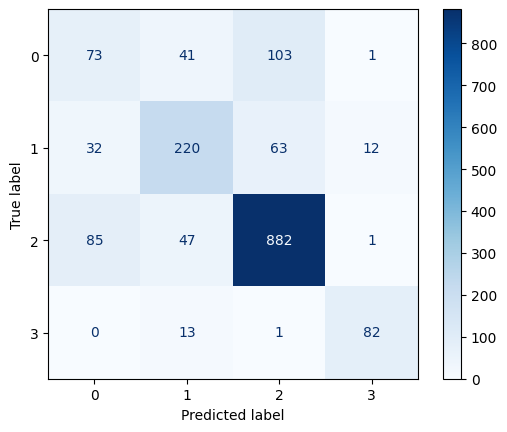

OSFL
Accuracy: 0.7001972386587771
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.91      0.85       621
           1       0.59      0.34      0.43       251
           2       0.27      0.29      0.28        80
           3       0.49      0.55      0.52        62

    accuracy                           0.70      1014
   macro avg       0.54      0.52      0.52      1014
weighted avg       0.68      0.70      0.68      1014



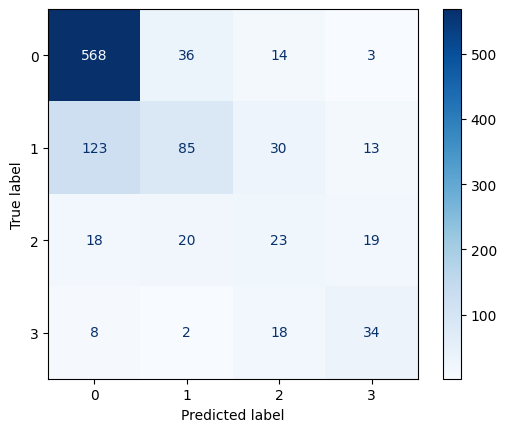

SCFL
Accuracy: 0.9635108481262328
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       933
           1       0.65      0.54      0.59        37
           2       0.78      0.78      0.78        40
           3       0.00      0.00      0.00         4

    accuracy                           0.96      1014
   macro avg       0.60      0.58      0.59      1014
weighted avg       0.96      0.96      0.96      1014



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


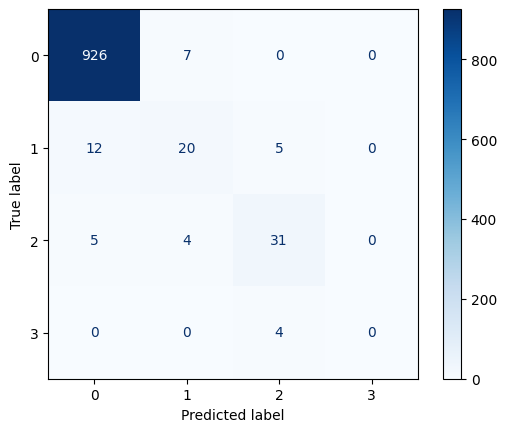

OSTM
Accuracy: 0.7238658777120316
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.77      0.77       390
           1       0.72      0.77      0.74       481
           2       0.53      0.39      0.45       103
           3       0.63      0.60      0.62        40

    accuracy                           0.72      1014
   macro avg       0.66      0.63      0.64      1014
weighted avg       0.72      0.72      0.72      1014



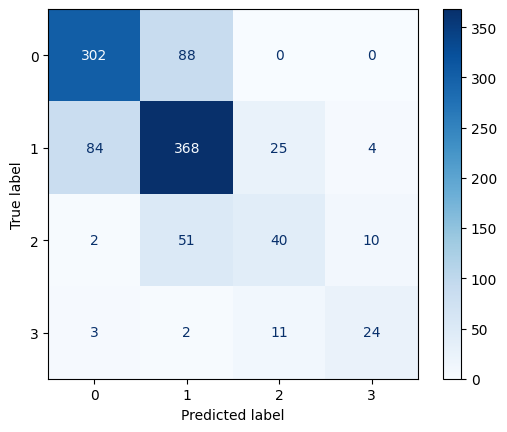

SCTM
Accuracy: 0.8136094674556213
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       661
           1       0.68      0.48      0.56       216
           2       0.62      0.74      0.67       115
           3       1.00      0.18      0.31        22

    accuracy                           0.81      1014
   macro avg       0.79      0.59      0.61      1014
weighted avg       0.81      0.81      0.80      1014



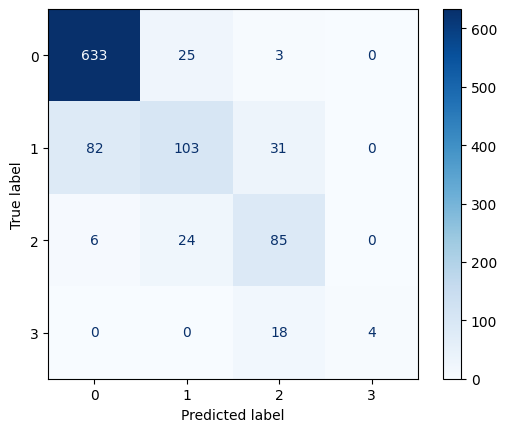

OSFM
Accuracy: 0.7130177514792899
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       565
           1       0.53      0.46      0.49       224
           2       0.41      0.18      0.25       104
           3       0.59      0.74      0.66       121

    accuracy                           0.71      1014
   macro avg       0.59      0.57      0.57      1014
weighted avg       0.69      0.71      0.69      1014



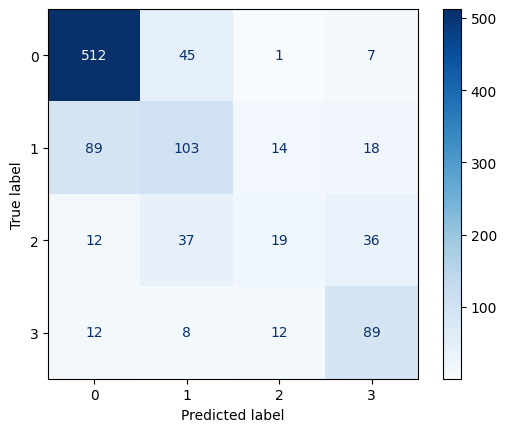

SCFM
Accuracy: 0.8214990138067061
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       679
           1       0.69      0.47      0.56       207
           2       0.64      0.77      0.70       111
           3       0.50      0.06      0.11        17

    accuracy                           0.82      1014
   macro avg       0.68      0.56      0.57      1014
weighted avg       0.81      0.82      0.81      1014



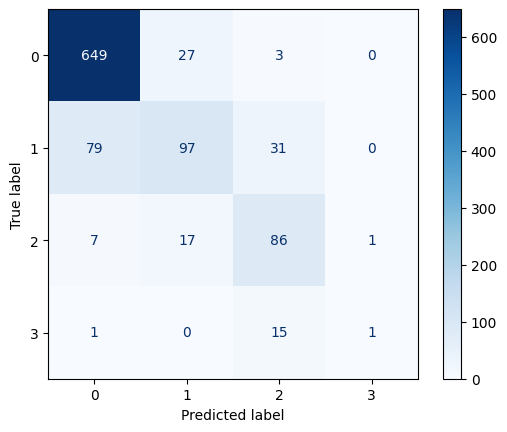

OSTL
Accuracy: 0.7938856015779092
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.90      0.90       653
           1       0.63      0.72      0.67       258
           2       0.33      0.06      0.10        54
           3       0.58      0.61      0.59        49

    accuracy                           0.79      1014
   macro avg       0.61      0.57      0.56      1014
weighted avg       0.78      0.79      0.78      1014



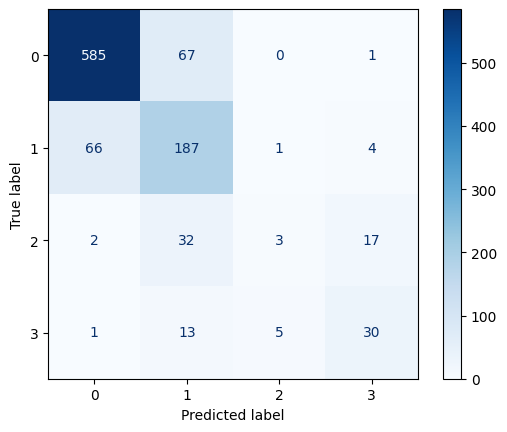

SCTL
Accuracy: 0.9615384615384616
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       940
           1       0.61      0.46      0.52        37
           2       0.68      0.84      0.75        32
           3       0.00      0.00      0.00         5

    accuracy                           0.96      1014
   macro avg       0.57      0.57      0.57      1014
weighted avg       0.96      0.96      0.96      1014



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


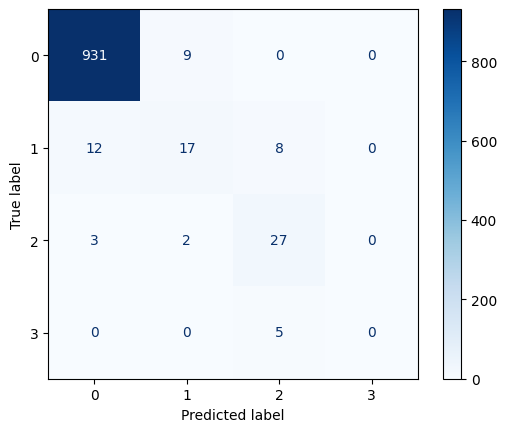

In [28]:
previous_n = 0
for k,v in target_values.items():
    k_y_pred = np.argmax(y_pred[:, previous_n:(previous_n+len(v))], axis=1)[test_nan_df[k]]
    k_y_true = np.argmax(y_true[:, previous_n:(previous_n+len(v))], axis=1)[test_nan_df[k]]
    previous_n =  previous_n + len(v)
    print(k.upper())
    print('Accuracy:', accuracy_score(k_y_true, k_y_pred))
    print('-'*75)
    print(classification_report(k_y_true, k_y_pred))
    cm = confusion_matrix(k_y_true, k_y_pred)
    cm_display = ConfusionMatrixDisplay(cm).plot(cmap='Blues')
    plt.show()
    print('='*75)

# predict for all data (output phase 1)

In [29]:
column_dicts = copy.deepcopy(target_values)

# Update cloned_target_values to convert specified keys to integers
for key in ['osfl', 'scfl', 'ostm', 'sctm', 'osfm', 'scfm', 'ostl', 'sctl']:
    if key in column_dicts:
        column_dicts[key] = list(map(int, column_dicts[key]))

In [30]:
data_train = df[df['subset'] == 'train'][['filename', 'kl_grade', 'subset', 'actual_path']].values.tolist()

data_val = df[df['subset'] == 'val'][['filename', 'kl_grade', 'subset', 'actual_path']].values.tolist()

data_test = df[df['subset'] == 'test'][['filename', 'kl_grade', 'subset', 'actual_path']].values.tolist()

In [31]:
class Predict_DataSet(Dataset):
    def __init__(self, data, transform=None):   
        self.data = data
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # Read image
        image = cv2.imread(self.data[index][3])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # Get label
        filename = self.data[index][0]
        kl_grade = self.data[index][1]
        subset = self.data[index][2]
        
        if self.transform:
            image = self.transform(image)

        return image, filename, kl_grade, subset

In [32]:
test_transforms = transforms.Compose([
    transforms.Resize((HEIGHT, WEIGHT)),
    transforms.ToTensor(),
    transforms.Normalize((0.6078, 0.6078, 0.6078), (0.1932, 0.1932, 0.1932)),
])

train_dataset = Predict_DataSet(data=data_train, transform=test_transforms)
val_dataset   = Predict_DataSet(data=data_val, transform=test_transforms)
test_dataset  = Predict_DataSet(data=data_test, transform=test_transforms)

train_loader  = torch.utils.data.DataLoader(train_dataset ,shuffle=False, batch_size = 32)
val_loader    = torch.utils.data.DataLoader(val_dataset ,shuffle=False, batch_size = 32)
test_loader   = torch.utils.data.DataLoader(test_dataset ,shuffle=False, batch_size = 32)

## test set

In [33]:
all_filenames = []
all_kl_grades = []
all_subsets = []
all_predictions = []

model.eval()
with torch.no_grad():
    for inputs, filenames, kl_grades, subsets in tqdm(test_loader):
        inputs  = inputs.to(device)
        outputs = model(inputs)
        
        all_filenames.extend(filenames)
        all_kl_grades.extend(kl_grades.cpu().numpy())
        all_subsets.extend(subsets)
        all_predictions.append(outputs.cpu().numpy())
        
all_predictions = np.concatenate(all_predictions, axis=0)


100%|██████████| 52/52 [00:15<00:00,  3.34it/s]


In [34]:
data = {
    'filename': all_filenames,
    'kl_grade': all_kl_grades,
    'subset': all_subsets,
}

column_names = []
for target, values in column_dicts.items():
    column_names.extend([f"{target}_{v}" for v in values])
    
for idx, col_name in enumerate(column_names):
    data[col_name] = all_predictions[:, idx]

df_results = pd.DataFrame(data)

df_results.to_csv('df_test.csv', index=False)

## train set

In [35]:
all_filenames = []
all_kl_grades = []
all_subsets = []
all_predictions = []

model.eval()
with torch.no_grad():
    for inputs, filenames, kl_grades, subsets in tqdm(train_loader):
        inputs  = inputs.to(device)
        outputs = model(inputs)
        
        all_filenames.extend(filenames)
        all_kl_grades.extend(kl_grades.cpu().numpy())
        all_subsets.extend(subsets)
        all_predictions.append(outputs.cpu().numpy())
        
all_predictions = np.concatenate(all_predictions, axis=0)

100%|██████████| 181/181 [00:54<00:00,  3.35it/s]


In [36]:
data = {
    'filename': all_filenames,
    'kl_grade': all_kl_grades,
    'subset': all_subsets,
}

column_names = []
for target, values in column_dicts.items():
    column_names.extend([f"{target}_{v}" for v in values])
    
for idx, col_name in enumerate(column_names):
    data[col_name] = all_predictions[:, idx]

df_results = pd.DataFrame(data)

df_results.to_csv('df_train.csv', index=False)

## val set

In [37]:
all_filenames = []
all_kl_grades = []
all_subsets = []
all_predictions = []

model.eval()
with torch.no_grad():
    for inputs, filenames, kl_grades, subsets in tqdm(val_loader):
        inputs  = inputs.to(device)
        outputs = model(inputs)
        
        all_filenames.extend(filenames)
        all_kl_grades.extend(kl_grades.cpu().numpy())
        all_subsets.extend(subsets)
        all_predictions.append(outputs.cpu().numpy())
        
all_predictions = np.concatenate(all_predictions, axis=0)

100%|██████████| 26/26 [00:09<00:00,  2.85it/s]


In [38]:
data = {
    'filename': all_filenames,
    'kl_grade': all_kl_grades,
    'subset': all_subsets,
}

column_names = []
for target, values in column_dicts.items():
    column_names.extend([f"{target}_{v}" for v in values])
    
for idx, col_name in enumerate(column_names):
    data[col_name] = all_predictions[:, idx]

df_results = pd.DataFrame(data)

df_results.to_csv('df_val.csv', index=False)